# A Gaussian approximation potential (GAP) for  the Zundel cation

The present notebook is meant to give you an overview of the main ingredients that you need to build an interatomic potential with `librascal` and use it in connection with i-Pi (https://github.com/cosmo-epfl/i-pi) to generate molecular dynamics (MD) trajectories of the system of interest. 
We will start from building a GAP model for Zundel cations ($H_5O_2+$), using a training set obtained via Bowman PES sampling, calculate its RMSE on a test set to check its performance and run a short NVT simulation at $\text{T} = 250\,\text{K}$. 

The mathematical framework that we are going to use is the kernel-GAP fitting method, using both total energies and atomic forces as target properties. Basically the GAP-model total energy of a zundel molecule is computed using the following expression: 

$$
                    E = E_0 + \sum_i \sum_{s=1}^M \alpha_s K(\bf{d_i} , \bf{d_s} )                   
$$

where $E_0$ represents an energy baseline (given usually by the sum of atomic self-contributions), $\bf{d_i}$ ($i = 1, \dots, N_{atoms}$) are the set of (normalized SOAP) descriptors describing an environment centred around atom $i$, $\bf{d_s}$ the set of descriptors corresponding to the environments of the sparse set (of size $M$) and K a kernel matrix that describes the similarity of two different atomic environments. In our application, the kernel is just the dot product, raised to some integer power $\zeta$: 

$$
        K(\bf{d_i} , \bf{d_s} ) \propto \left| \bf{d_i} \cdot \bf{d_s} \right|^{\zeta}           
$$

Finally $\alpha_s$ represents the weights of each sparse environment, to be determined using Kernel-Ridge Regression (KRR). For extensive details on the SOAP GAP-model fitting procedure and interesting physical applications, we invite the reader to refer to the book chapter [1].
Details on the implementation in `librascal` are instead given in the companion publication [2].

[1]: M. Ceriotti, M.J. Willatt, and G. Csányi, in Handbook of Materials Modeling (Springer International Publishing, Cham, 2018), pp. 1–27. https://doi.org/10.1007/978-3-319-42913-7_68-1

[2]: F. Musil, M. Veit, A. Goscinski, G. Fraux, M.J. Willatt, M. Stricker, T. Junge, and M. Ceriotti, J. Chem. Phys. 154, 114109 (2021). https://doi.org/10.1063/5.0044689

## Getting started 

In order to be able to fit a potential with `librascal` (the model evaluator) and interface it with i-Pi (the MD engine) we first need to have both softwares available and correctly installed. For `librascal`, the following should suffice:
```bash
$ pip install git+https://github.com/cosmo-epfl/librascal.git
```

and the same for i-PI:
```bash
$ pip install git+https://github.com/cosmo-epfl/i-pi.git
```
If these steps don't work, try looking at the `README.rst` files of the respective repositories for further instructions.

### Importing all the necessary Librascal modules

Let us start from the import of all the necessary modules and classes. In `librascal`, these are: 

1) the SOAP descriptors of a structure, by means of the `SphericalInvariants` class;

2) the kernels between a set of environments and the sparse set (the `Kernel` class);

3) the GAP model itself, which is saved as an object of the `KRR` class. The predict method of the same class will allow us to give predictions to new unseen structures. 

NOTE: it is assumed that the input format for the training set and the test set is an ASE-compatible (e.g. extended-XYZ) file, which is then converted into an array of ASE Atoms objects, each one corresponding to a specific structure. `librascal` uses these frames to compute the representations and predict the properties of new structures. In this example on zundel cations, the target energies to build the model with are reported in the `zundel_energies.txt` file, while the atomic forces are additional columns of the xyz. 

Alternatively, global target properties can be reported in the header line following the ASE format.

In [1]:
%matplotlib inline
from matplotlib import pylab as plt

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time

from rascal.models import gaptools, KRR
from rascal.utils import dump_obj, load_obj
from rascal.representations import SphericalInvariants

In [2]:
cd i-PI/zundel/

/ssd/local/code/librascal-zundel/examples/i-PI/zundel


In the snippets below we extract the relevant properties for each ASE frame. We load the total potential energies and we use the `ASE.Atoms.arrays` methods to get the atomic forces. For more information on how to use ASE-related methods, check the [ASE Atoms documentation](https://wiki.fysik.dtu.dk/ase/ase/atoms.html).

In [3]:
# Load the first N structures of the zundel dataset
N_dataset = 1000
frames = read('zundel_dataset.xyz', index=':{}'.format(N_dataset))
energies = np.loadtxt('zundel_energies.txt')[:N_dataset] 

#Keys of the arrays dictionary
print(frames[0].arrays.keys())

dict_keys(['numbers', 'positions', 'forces'])


In [4]:
def extract_forces(frames,array_key='zeros'):
    f = []
    for frame in frames:
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    try:
        f = np.concatenate(f)
    except:
        pass
    return f

In [5]:
forces = extract_forces(frames, 'forces')

## Build the GAP model

The preliminary step towards building a GAP model is defining a training and a test set. The training set is built by random selection of $800$ of the available structures, while the remaining $200$ will represent the test set. At this point, we also extract the distinct atomic species present in our system, define the atomic baseline energy and extract the information regarding energies and forces in the train and test set structures, which we will need later on.

In [6]:
def train_test_split(ids, n_train, frames_all, y_all, f_all):
    """Perform a train-test split
    
    Parameters
    ----------
    
    ids: list(int), size N
        Ordering (e.g. random shuffle) for selecting the split
    n_train: int
        Number of structures in the training set
    frames_all: list(ase.Atoms), length N
        List of all frames in the dataset
    y_all: list(float) or 1-D array, length N
        Set of all function values (energies) in the dataset
    f_all: list or 3-D array, size (N, M, 3)
        Set of all forces (negative gradients) in the dataset
        M is the maximum number of atoms in any one structure
        
    Returns
    -------
    
    ((list(Atoms): frames_train, 1-D array: y_train, 3-D array: f_train),
     (list(Atoms): frames_test, 1-D array: y_test, 3-D array: f_test))
    """
    train_ids = ids[:n]
    test_ids = ids[n:]

    frames_train = [frames_all[ii] for ii in train_ids]
    frames_test = [frames_all[ii] for ii in test_ids]
    y_train = np.array(y_all)[train_ids]
    y_test = np.array(y_all)[test_ids]
    f_train = np.array(f_all).reshape(len(ids), 7, 3)[train_ids].reshape(-1, 3)
    f_test = np.array(f_all).reshape(len(ids), 7, 3)[test_ids].reshape(-1, 3)
    return ((frames_train, y_train, f_train), (frames_test, y_test, f_test))

In [7]:
# Number of structures to train the model with
n = 800


# Select randomly n structures for training the model
ids = list(range(N_dataset))
np.random.seed(10)
np.random.shuffle(ids)
f = extract_forces(frames, 'forces')
((frames_train, y_train, f_train),
 (frames_test, y_test, f_test)) = train_test_split(ids, n, frames, energies, forces)

We also define an "atomic energy baseline", which defines a constant contribution for each atom type in order to shift the mean of the potential energy function close to zero and make it easier to fit.

In [7]:
# Atomic energy baseline
global_species = set()
for frame in frames:
    global_species.update(frame.get_atomic_numbers())
global_species = np.array(list(global_species))

atom_energy_baseline = np.mean(energies)/(frames[0].get_global_number_of_atoms())
energy_baseline = {int(species): atom_energy_baseline for species in global_species}

Now we proceed with the actual calculation of the SOAP vectors of our training set. We need to specify an hyperparameters dictionary, which `librascal` uses to compute the structural features. The meaning of each hyperparameter and how to correctly set them is reported in [the `SphericalInvariants` documentation](https://cosmo-epfl.github.io/librascal/reference/python.html#rascal.representations.SphericalInvariants). These hyperparameters can be used as default values, but a careful optimization of the interaction cutoff might be required in the case the material under investigation might present some mid- or long-range order. 

For the actual calculation of the SOAP features, we first create an object of the `SphericalInvariants` class, defined by its hyperparameters. The methods that we then need to use are `transform()}`, which yields a second object called the `manager` containing the representation, while `get_features()` converts it into an $NxM$ matrix, $N$ being the number of atomic environments in the training set and M the number of features per each environment.

Finally, note that we first request the calculation of descriptors _without_ gradients (`compute_gradients=False`) to avoid using too much memory.  We will create a version _with_ gradients later on when we need to make a model that computes forces.

In [9]:
# define the parameters of the spherical expansion
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.0, 
              max_radial=6, 
              max_angular=4, 
              gaussian_sigma_constant=0.5,
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=3.5,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False
              )

The following snippet computes the descriptors and the managers for each frame, which will represent the expensive part of the calculation, in terms of memory usage.

NOTE: the `librascal` structure manager only works if the atoms have been wrapped within the cell provided in the input file using e.g. `ase.Atoms.wrap()` (which is automatically called if `auto_wrap==True`, as below) or one of the structure preprocessors provided in `rascal.neighbourlist.structure_manager` module (useful especially for non-periodic structures).

In [9]:
start = time()
soap, feature_list = gaptools.calculate_representation(frames, hypers, auto_wrap=True)
print ("Execution: ", time()-start, "s")


Execution:  0.12206697463989258 s


At this point, we can also define the **sparse set**, i.e. the set of (ideally) "maximally diverse" environments that will be used as basis points of the kernel ridge regression (KRR, mostly equivalent to GAP) model. We can choose the number of sparse environments in `librascal` per each atomic species, by defining a dictionary containing (atomic number, number of environments) pairs. The CURFilter class then selects out the most "representative" environments according to the representation that we provide as the input object and by applying the CUR decomposition [3].

[3]: 1 M.W. Mahoney and P. Drineas, PNAS 106, 697 (2009). https://doi.org/10.1073/pnas.0803205106

In [11]:
n_sparse = {1:50, 8:100}
X_sparse = gaptools.sparsify_environments(soap, feature_list, n_sparse, selection_type="CUR")

The number of pseudo points selected by central atom species is: {1: 50, 8: 100}
Selecting species: 1
Reconstruction RMSE=1.463e+00
Selecting species: 8
Reconstruction RMSE=1.577e-02


As shown in eq. $(1)$, in order to fit a GAP potential we need to compute the kernels of all the training structure descriptors and the sparse set, as well as the gradients w.r.t. the atomic positions, if we wish to fit the atomic forces. We do so by using the `compute_kernels` utility of `gaptools`; note that this can also take some time.  (Note: Yes, this does need a version of the representation that can compute gradients, but this is handled internally; the representation gradients are calculated one by one for each structure in order to avoid using too much memory.)

In [12]:
start = time()
(k_obj, K_sparse_sparse, K_full_sparse, K_grad_full_sparse) = gaptools.compute_kernels(
    soap,
    feature_list,
    X_sparse,
    soap_power=2
)
print("Kernel compute time: ", time()-start, "s")


Execution:  1.5349509716033936 s


The "sparse-sparse" kernel is between all the sparse environments with themselves, the "full-sparse" is between each structure (summed over the atoms) and the sparse envronments, and "grad_full_sparse" is the _gradient_ of the full-sparse kernel with respect to each atom in the respective structure (which is what we need to train with forces).

In [13]:
K_sparse_sparse.shape

(375, 375)

In [14]:
K_full_sparse.shape

(1000, 375)

In [15]:
K_grad_full_sparse.shape

(21000, 375)

(This would be a good place to save the kernels to disk if you're planning on doing anything with them afterwards!)

Let's get the subset of the full-sparse kernel that corresponds only to the training set:

In [16]:
K_train_sparse, K_grad_train_sparse = gaptools.extract_kernel_indices(
    ids[:n], K_full_sparse, K_grad_full_sparse, natoms=7
)

In [17]:
K_train_sparse.shape

(800, 375)

In [18]:
K_grad_train_sparse.shape

(16800, 375)

Finally, we group everything together to build the GAP model, which basically uses the kernel matrices to regress the weights $\{\alpha_s\}_{s=1}^M$ on each sparse environment. The regularization parameters of the KRR (for both energies and forces) help avoid overfitting and account for small statistical variations in the training data points.  Finally, we use the per-atom energy baseline defined above to shift the energy and make sure the model is predicting about a mean close to zero.

In [19]:
weights = gaptools.fit_gap_simple(
    frames_train,
    K_sparse_sparse,
    y_train,
    K_train_sparse,
    energy_regularizer_peratom=1E-3,
    forces=f_train,
    kernel_gradients_sparse=K_grad_train_sparse,
    energy_atom_contributions=energy_baseline,
    force_regularizer=1E-2,
    solver="RKHS"
)

We use the weights to build a KRR object, which we can save as .json file for future use. For this last bit we use the `dump_obj` method (part of the `rascal.utils.io` module).

In [20]:
model = KRR(weights, k_obj, X_sparse, energy_baseline,
            description="GAP for the Zundel cation")
dump_obj('zundel_model.json', model)
np.savetxt('Structure_indices.txt', ids)

## Assessment of the model

To perform a basic assessment of the model we have fitted, we need to predict the properties (energies and forces) of a test set. In the calculation of the model that we have fitted previously, we have randomly splitted the original dataset in a training set of 800 structures and a test set of another 200.  We must be careful to use the same training and testing set as defined above (under the section "Building a GAP model") and not re-shuffle the dataset!

In [21]:
model = load_obj('zundel_model.json')

# Uncomment the lines below if you are starting from this cell
# n_test = 800
# ids = np.loadtxt('Structure_indices.txt')
# (_, (frames_test, y_test, f_test)) = train_test_split(ids, n_test, frames, energies, forces)
# k_obj = model.kernel

Let us now compute the predictions on the test set, using the `predict()` and `predict_forces()` methods of the `KRR` class. At this point we need to compute the SOAP representation of the test set structures. It is important to stress however that this will not cause any issue regarding memory usage, because all we need is the predictions, so we can compute the managers of the test set structures one by one and calculate the predictions right away.

In [22]:
hypers_grad = hypers.copy()
hypers_grad['compute_gradients'] = True
soap_grad = SphericalInvariants(**hypers_grad)

In [23]:
# make predictions on the test set
y_pred = []
f_pred = []

for f in tqdm(frames_test):
    f.wrap()
    m = soap_grad.transform(f)
    y_pred.append(model.predict(m))
    f_pred.append(model.predict_forces(m))

y_pred = np.array(y_pred).flatten()
f_pred = np.array(f_pred)

Let us now compute the overall performance of the model. This is done by calculation of the Root-Mean-Square Error (RMSE), i.e. the standard deviation of the residuals according to the standard formula:

$$
       \text{RMSE} = \sqrt{\frac{1}{n_{\text{test}}}\sum_i (y_{\text{pred}}^{i} - y_{\text{test}}^{i})^2}
$$
   
which we can compare to the standard deviation of the test set itself to quantify how much the model captures the energy variations in the test set. The $\% \text{RMSE}$ of our model is about $5 \%$ of the training set STD, which is sufficiently accurate to run MD safely. 

Finally we plot a "correlation plot", to observe how well the predictions on the test set correlate with the reference DFT-computed energies.

NOTE: by just repeating this procedure and fitting potentials with increasing training set size, one can also construct the learning curve of the GAP.

In [24]:
from rascal.utils import get_score

score = get_score(y_pred, y_test)
RMSE = score['RMSE']
sigma_test = np.std(y_test)

score = get_score(f_test.flatten(), f_pred.flatten())
fRMSE = score['RMSE']

print("RMSE = ", RMSE*1000.0, "meV")
print("Sigma test set = ", sigma_test, " eV")
print("%RMSE = ", RMSE/sigma_test*100.0, " %")
print("force RMSE = ", fRMSE, "eV/A")

RMSE =  30.087996494496597 meV
Sigma test set =  0.274800153468654  eV
%RMSE =  10.949046466936812  %


Text(0, 0.5, 'reference energies [eV]')

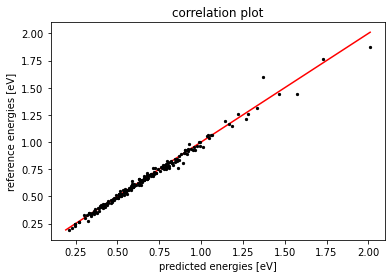

In [25]:
plt.scatter(y_test, y_pred, s=5.0, c = 'black')
lims = [
    np.min([np.min(y_pred), np.min(y_test)]),  # min of both axes
    np.max([np.max(y_pred), np.max(y_test)]),  # max of both axes
]

# now plot both limits against eachother
plt.plot(lims, lims, 'r-', zorder=0)
plt.title("correlation plot")
plt.xlabel("predicted energies [eV]")
plt.ylabel("reference energies [eV]")

## MD simulations

Now we are going to use the fitted model to perform a simple NVT simulation at $\text{T} = 250\,$K using the i-Pi interface with librascal. For that we will use a communication socket run by i-Pi, which basically outputs a structure produced by the MD and gives it in input to Librascal. This will in turn return energies, forces and stresses by means of the `GenericMDCalculator` class of Librascal. 

The job itself will generate a parent process (i-Pi) which contains information of the ensemble, the step needed for the time-integration, the thermostat characteristics, and all other trajectory-related infos. All these information are initially stored in an input.xml file as specified in the i-Pi documentation at https://github.com/cosmo-epfl/i-pi and given as inputs to i-Pi. The Librascal calculator is then launched as a child process and exchanges information with the MD driver.  

The Librascal driver in i-Pi needs some input parameters, that can be given directly in the command line when the driver is called. To check the needed information, just use the --help option when calling it, as shown below.

NOTE: in what follows, it is assumed that your i-Pi and Librascal folders lie in a common directory. Check and modify the path below when defining IPI if this is not the case.

Check the XML file in the `i-PI/zundel` folder to quickly read the relevant information about the MD settings. Importantly, the `<properties>` tag gives you information about the physical properties that are printed out by i-PI. This simulation gives as output a .out file containing the time-evolution of all the relevant physical quantities, while the .xc.xyz file contains the full trajectory, which you can later visualize with VMD. The file `h5o2+.xyz` is both used by i-PI as a starting configuration of the trajectory and by Librascal as a template to load information about chemical species and number of atoms per species of the system.

As the simulation evolves you can plot some interesting physical properties, for instance the MD kinetic energy, the total potential energy and the pressure, and check for thermalization.

An example script is provided to launch a MD simulation with i-PI and the model that has just been fitted `zundel_model.json` (note that you may need to edit some variables in the script, or set `$PATH` and `$PYTHONPATH` appropriately, in order to make it work on your system):

```bash
bash ./run.sh
```

and the simulation can be monitored with the following cell.

[Text(0.5, 0, 'time [ps]')]

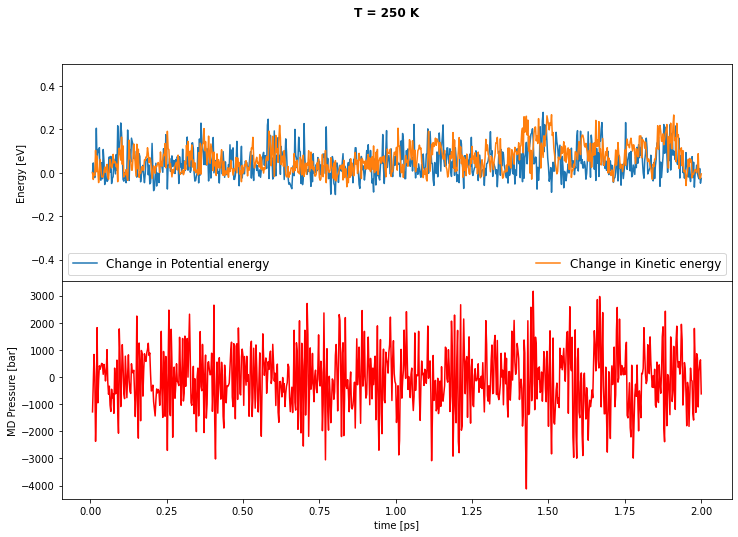

In [18]:
#Plotting the results of the simulations
try:
    f = open('zundel.out', 'r')
except FileNotFoundError:
    f = open('zundel.example.out', 'r')
lines=f.readlines()[13:]

Nframes = len(lines)
steps = np.zeros((Nframes, 1), dtype=float)
times = np.zeros((Nframes, 1), dtype=float)
KE = np.zeros((Nframes, 1), dtype=float)
PE = np.zeros((Nframes, 1), dtype=float)
Pressure = np.zeros((Nframes, 1), dtype=float)

i = 0
for x in lines: 
    steps[i] = float(x.split()[0])
    times[i] = float(x.split()[1])
    KE[i] = float(x.split()[4])
    PE[i] = float(x.split()[5])
    Pressure[i] = float(x.split()[6])
    i += 1

f, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
f.subplots_adjust(hspace=0)
f.suptitle('T = 250 K', fontweight='bold')

axs[0].plot(times, (KE - KE[0]), linewidth = 1.5, label = 'Change in Potential energy')
axs[0].plot(times, (PE - PE[0]), linewidth = 1.5, label = 'Change in Kinetic energy')
axs[0].set(ylabel= 'Energy [eV]')
axs[0].set_ylim(-0.5, 0.5)
axs[0].legend(ncol = 2, mode='expand', prop={'size': 12}, loc="lower center")

axs[1].plot(times, Pressure, linewidth = 1.5, color = 'red')
axs[1].set(ylabel= 'MD Pressure [bar]')
axs[1].set(xlabel= 'time [ps]')